In [1]:
from apps.contributors.calculate_stints import create_stints_from_pdfs, create_stints_from_bylines
from apps.contributors.tasks import connect_contributor_to_user, update_status, update_contributor_status
from django.utils import timezone
from IPython.core.debugger import set_trace as bp
from PIL import Image
from utils.merge_model_objects import merge_instances
import logging

In [2]:
# test model merge
ingis = Contributor.objects.get(display_name__istartswith='Ingeborg Grindheim Slinde')
pingis = (
    Contributor.objects.filter(display_name='Foo Bar').first() or
    Contributor.objects.create(display_name='Foo Bar')
)
bl = ingis.byline_set.first()
bl.contributor = pingis
bl.save()
pingis.byline_photo = ingis.byline_photo
ingis.byline_photo = None
ingis.save()
pingis.save()
ingis.refresh_from_db()
pingis.refresh_from_db()
for ngis in ingis, pingis:
    print(ngis, ngis.bylines_count())
merge_instances(ingis, pingis)
for ngis in ingis, pingis:
    print(ngis, ngis.bylines_count())

Ingeborg Grindheim Slinde 2
Foo Bar 1
Ingeborg Grindheim Slinde 3
Foo Bar 0


In [3]:
ingis.stint_set.all()

<StintQuerySet [<Stint: journalist: Ingeborg Grindheim Slinde 2017-06-04 – >]>

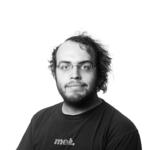

In [4]:
kenneth =  Contributor.objects.get(display_name='Kenneth Haug')
kenneth.byline_photo.delete_thumbnails()
Image.open(kenneth.byline_photo.preview)

In [5]:
for cn in Contributor.objects.all():
    im = cn.get_byline_image()
    print(f'{str(cn):<30}{im} {im and im.imagehash} ')

Hans Christian Paulsen        False False 
Hanna Skotheim                Hanna-Skotheim.jpg b3e14de898b6c4e8 
Kristina Kvammen              Kristina-Kvammen.jpg 2a6a62f8c9c884c8 
Mads Randen                   Mads-Randen.jpg 12b0a1f0dcb44c4e 
Markus Slettholm              Markus-Slettholm.jpg 201031a532e0948a 
Emilie Solberg                Emilie-Solberg.jpg 2040a161e989898c 
Regine Stokstad               Regine-Stokstad.jpg 2040aae262e18884 
Runa Fjellanger               Runa-Fjellanger.jpg 2000f16464f09396 
Mathias Gravdehaug            Mathias-Gravdehaug.jpg 30007074b470e810 
Signe Rosenlund-Hauglid       Signe-Rosenlund-Hauglid.jpg 10a521d484928786 
Lise Blekastad                Lise-Blekastad.jpg b46269d9d8e8b892 
Joakim Stene Preston          False False 
Birk Tjeldflaat Helle         False False 
Erlend Dalhaug Daae           False False 
Maria Terese Kittilsen        Maria-Terese-Kittilsen.jpg a4a230f0c696d6d4 
Jens Lægreid                  False False 
Morten Oftedal Schwenke 

In [7]:
since = timezone.now() - timezone.timedelta(days=10000)
pdfs = PrintIssue.objects.filter(issue__publication_date__gt=since)
dry_run=False
Stint.objects.all().delete()
#logging.disable(logging.DEBUG)
create_stints_from_pdfs(pdfs, dry_run)
create_stints_from_bylines(dry_run, since)
logging.disable(logging.NOTSET)
Stint.objects.count()

15:38:11 2017-09-30 [DEBUG] apps.contributors.calculate_stints calculate_stints.py:28   (create_stints_from_pdfs)
	2017-08-16 /media/pdf/3628ebbaa5df11e783a60242ac12000b/universitas_2017-16_mag.pdf


15:38:11 2017-09-30 [DEBUG] apps.contributors.calculate_stints calculate_stints.py:28   (create_stints_from_pdfs)
	2017-09-06 /media/pdf/39208bdea5df11e783a60242ac12000b/universitas_2017-19_mag.pdf
magasinredaktør: Signe Rosenlund-Hauglid
magasinfotosjef: Kristina Kvammen

15:38:12 2017-09-30 [DEBUG] apps.contributors.calculate_stints calculate_stints.py:28   (create_stints_from_pdfs)
	2017-09-06 /media/pdf/3c5f58b6a5df11e783a60242ac12000b/universitas_2017-19.pdf
daglig leder: Joakim Stene Preston
redaktør: Birk Tjeldflaat Helle
nyhetsleder: Mads Randen
fotosjef: Erlend Dalhaug Daae
desksjef: Lise Blekastad
nettredaktør: Markus Slettholm
magasinredaktør: Signe Rosenlund-Hauglid
utenriksredaktør: Emilie Solberg
kulturredaktør: Regine Stokstad
debattredaktør: Runa Fjellanger
anmelderredaktør

24

In [12]:
User.objects.filter(username__startswith='(').delete()
for contributor in Contributor.objects.all():
    if contributor.stint_set.active():
        contributor.status = contributor.ACTIVE
        connect_contributor_to_user(contributor, create=True)
    elif contributor.status == contributor.ACTIVE:
        contributor.status = contributor.RETIRED
    contributor.save()
    print(f'{str(contributor):<30} {contributor.get_status_display():<9} {contributor.user}')

19:35:01 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Kristina Kvammen without an email

19:35:01 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Mads Randen without an email

19:35:01 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Markus Slettholm without an email

19:35:01 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Emilie Solberg without an email

19:35:01 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Regine Stokstad without an email

19:35:01 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Runa Fjellanger without an email

19:35:02 2017-09-30 [WARNING] apps.contribu

Hans Christian Paulsen         Ukjent    None
Hanna Skotheim                 Ukjent    HannaSkotheim
Kristina Kvammen               Aktiv     None
Mads Randen                    Aktiv     None
Markus Slettholm               Aktiv     None
Emilie Solberg                 Aktiv     None
Regine Stokstad                Aktiv     None
Runa Fjellanger                Aktiv     None
Mathias Gravdehaug             Aktiv     None
Signe Rosenlund-Hauglid        Aktiv     None
Lise Blekastad                 Aktiv     None
Joakim Stene Preston           Aktiv     jspreston


19:35:02 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Erlend Dalhaug Daae without an email

19:35:02 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Ingeborg Grindheim Slinde without an email

19:35:02 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Angelique Culvin without an email



Birk Tjeldflaat Helle          Aktiv     BirkTH
Erlend Dalhaug Daae            Aktiv     None
Maria Terese Kittilsen         Ekstern   None
Jens Lægreid                   Ekstern   None
Morten Oftedal Schwenke        Ukjent    None
Marcus Pettersen Irgens        Ekstern   None
Nomen Nescio                   Ekstern   None
Ingeborg Grindheim Slinde      Aktiv     None
Henriette Dæhli                Slutta    None
Sondre Myhre                   Slutta    sondremyhre
Marianne Demmo                 Slutta    None
Angelique Culvin               Aktiv     None
Kenneth Haug                   Slutta    kennethkandolfhaug
Hannah Berg                    Slutta    hannahberg
Svein Stølen                   Slutta    None
Kristine Sørheim               Slutta    None


19:35:02 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Øivind Hovland without an email

19:35:02 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Roar Bye Blåsmo-Falnes without an email



Simen August Askeland          Slutta    None
Fredrik Arff                   Slutta    None
Gro Bjørnerud Mo               Slutta    None
Håken Lid                      Slutta    haakenlid
Øivind Hovland                 Aktiv     None
Mari Mjaaland                  Slutta    marimjaaland
Torbjørn Røe Isaksen           Slutta    None
Kristina Holt                  Slutta    kristinaholt
Odin Drønen                    Slutta    odindro
Lina Christensen               Slutta    linachristens
Pia Ottilia Danielsen          Slutta    None
Kari Eiring                    Slutta    karieiring
Adrian Simen Holm              Slutta    adriansimenholm
Åsmund M. Kvifte               Slutta    None
Gin&Tonic                      Slutta    None
Aurora Sæverud                 Slutta    None
Stine Marie Tangenes           Slutta    None
Roar Bye Blåsmo-Falnes         Aktiv     None
Marianne Giske                 Slutta    None
Stine Rotnes                   Slutta    None
Olav Riise                    

19:35:02 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Lucas Ibanez-Fæhn without an email

19:35:02 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Maral Zadeh without an email

19:35:02 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Johannes Fjeld without an email

19:35:02 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Frida Fliflet without an email

19:35:02 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Mikkel Ihle Tande without an email

19:35:02 2017-09-30 [WARNING] apps.contributors.tasks     tasks.py:33   (connect_contributor_to_user)
	Cannot create user for Vera Maria Gjermundsen without an email

19:35:02 2017-09-30 [WARNING] apps.c

Lucas Ibanez-Fæhn              Aktiv     None
1997. 20. Mantel               Slutta    None
Therese Norum Halvorsen        Slutta    None
Maral Zadeh                    Aktiv     None
Johannes Fjeld                 Aktiv     None
Julie Brundtland               Slutta    None
Frida Fliflet                  Aktiv     None
Kristian Müller Andersen       Slutta    None
Eirin Bruholt                  Slutta    None
Mathea Reine-Nilsen            Slutta    None
Ragna Louise Sandvoll          Slutta    None
Mikkel Ihle Tande              Aktiv     None
Vera Maria Gjermundsen         Aktiv     None
Peder Ebbesen                  Slutta    None
Camilla Alexandra Lie          Aktiv     None
Nicolas Perez Prieto           Slutta    None


In [20]:
from django.utils import timezone

# WIP

def update_active(inactive_limit=timezone.timedelta(days=150)):
    today = timezone.now().date()
    for contributor in Contributor.objects.all():
        all_bylines = contributor.byline_set.exclude(story__publication_date=None)
        debatt_bylines = all_bylines.filter(story__story_type__section__title='Debatt')
        status = Contributor.UNKNOWN
        if all_bylines.count() == debatt_bylines.count():
            status = contributor.EXTERNAL
        elif contributor.stint_set.count() > 0:
            latest = contributor.stint_set.latest('start_date')
            if not latest.end_date:
                  
                delta = today - latest.end_date
                if delta < timezone.timedelta(0):
                    pass
                    
                    
            if today - latest.end_date > inactive_limit:
                status = contributor.RETIRED
            if today - latest.end_date > inactive_limit:
                pass
            else:
                status = contributor.ACTIVE
        if status != contributor.status:
            contributor.status=status 
            contributor.save(update_fields=['status'])
        
        print(f'{str(contributor):<40} {contributor.get_status_display():<10} {contributor.byline_set.count():>5}')

update_active()
unknowns = Contributor.objects.filter(status=Contributor.UNKNOWN)
active = Contributor.objects.filter(status=Contributor.ACTIVE)
retired = Contributor.objects.filter(status=Contributor.RETIRED)
print(unknowns.count(), active.count(), retired.count())

Hans Christian Paulsen                   Ukjent         2
Hanna Skotheim                           Ukjent         1
Kristina Kvammen                         Ekstern        0
Mads Randen                              Ekstern        0
Markus Slettholm                         Ekstern        0
Emilie Solberg                           Ekstern        0
Regine Stokstad                          Ekstern        0
Runa Fjellanger                          Ekstern        0
Mathias Gravdehaug                       Ekstern        0
Signe Rosenlund-Hauglid                  Ekstern        0
Lise Blekastad                           Ekstern        0
Joakim Stene Preston                     Ekstern        0
Birk Tjeldflaat Helle                    Ekstern        0
Erlend Dalhaug Daae                      Ekstern        0
Maria Terese Kittilsen                   Ekstern        1
Jens Lægreid                             Ekstern        2
Morten Oftedal Schwenke                  Ukjent         1
Marcus Petters

TypeError: unsupported operand type(s) for -: 'datetime.date' and 'NoneType'